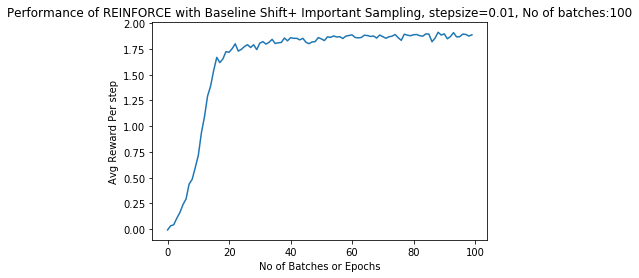

In [2]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
import gym_envs
import random
from random import choices
import matplotlib.pyplot as plt


env = gym.make('grid_world-v0')
M = env.action_space.n
N1 = env.state_space.n
breakout = True
N = N1*N1
k = 0
d = {}
for i in range(N1):
    for j in range(N1):
        d.update([((i,j),k)])
        k+=1

theta = np.zeros((M,N))
choice_a = [0,1,2,3]

rew = np.ones((M,N))
alpha = 0.1
ep_max = 100
epsilon = 0
t_steps = 30
p = np.zeros((M,N))
dist = [epsilon, 1-epsilon]
choice = [1,2]

def softmax(s, policy):
    
    #p_theta = np.exp(np.multiply(theta[:,s],rew[:,s]))
    p_theta = np.exp(policy[:,s])
    #p_theta = np.exp(policy_g[:,s])
    #print(np.linalg.norm(theta))
    return p_theta/np.sum(p_theta), np.argmax(p_theta/np.sum(p_theta))

count= 0

def softmax_complete():
    P_Theta = np.zeros((M,N))
    for i in range(N):
        p_theta = np.exp(theta[:,i])
        p_theta = p_theta/np.sum(p_theta)
        P_Theta[:,i] = p_theta
        #print(np.multiply(theta[:,s],rew[:,s]))
        #print(rew[:,s])
    print('Finally:', P_Theta)
    #tmp = np.argmax(P_Theta,axis=0)
    tmp_star = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            s = d[(i,j)]
            f = np.amax(P_Theta[:,s])
            f1 = np.argmax(P_Theta[:,s])
            tmp_star[4-i,j] = f1
    print(tmp_star)
 
rew_p_st = np.zeros(100)
iteration = np.zeros_like(rew_p_st)  
policy_new = theta    
for j in range(100):
    count += 1
    R = np.zeros((ep_max,1))
    grd = np.zeros((ep_max,M,N))
    ep_sum = np.zeros((M,N))
    theta_old = theta
    num = 0
    den = 0
    
    p_arr_old = np.zeros(t_steps)
    p_arr_new = np.zeros(t_steps)
    p_ratio = np.zeros(t_steps)
    
    for i in range(ep_max):
        
        env.reset()
        s1,s2 = env.state
        s = d[(s1,s2)]
        
        for t in range(t_steps):
#            
            tmp1, tmp2  = softmax(s, theta)
            
            tmp3 = [tmp1[0], tmp1[1], tmp1[2], tmp1[3]]
            tmp = random.choices(choice_a, tmp3)
            a = tmp[0]
            
            p_arr_old[t] = tmp3[a]
            tmp4,tmp5 = softmax(s, policy_new)
            p_arr_new[t] = tmp4[a]
            p_ratio[t] = p_arr_new[t]/p_arr_old[t]
            
            
            obs, reward, done, info = env.step(a)
            rew_p_st[j] = rew_p_st[j] + reward
            R[i] += reward
            phi = np.zeros((M,N))
            phi[a,s] = rew[a,s]
            grd[i,:,:] += phi 
            p_theta, a = softmax(s, theta)
            
            for ac in range(M):
                phi = np.zeros((M,N))
                phi[ac,s] = rew[ac,s]
                grd[i,:,:] -= p_theta[ac]*phi
            
            s1,s2 = obs
            s = d[(s1,s2)]
        
        num += (np.linalg.norm(np.ravel(grd[i,:,:]))**2)*R[i]
        den += (np.linalg.norm(np.ravel(grd[i,:,:]))**2)
        
        ep_sum += (1/ep_max)*(R[i]-num/den)*grd[i,:,:]*np.prod(p_ratio)
        
    #print('Count is: ', count)
    theta = policy_new
    policy_new = policy_new + alpha*ep_sum
    #theta = theta_old + alpha*ep_sum

    #print(np.linalg.norm(theta-theta_old))
    rew_p_st[j] = rew_p_st[j]/(ep_max*t_steps)
    iteration[j] = j

#softmax_complete()
#print('Count is: ', count)
plt.plot(iteration,rew_p_st)
plt.xlabel('No of Batches or Epochs')
plt.ylabel('Avg Reward Per step')
plt.title('Performance of REINFORCE with Baseline Shift+ Important Sampling, stepsize=0.01, No of batches:100')
plt.show()    
#exit()

In [3]:
import pandas as pd
resultdict = {'Iteration':iteration,'BS_IS_REINFORCE_reward':rew_p_st}
df = pd.DataFrame.from_dict(resultdict)
df.to_csv('AblationStudy_Final.csv')